###Classify images containing the seven wonders of the world using PyTorch

PyTorch is an object oriented framework for deep learning. This means that the functionality is seperated into different classes. 
For our use case we use the following PyTorch modules:
1. Dataset containing training and test images
2. Dataloader that can be used for iterating and batching over the actual data
3. CNN Model made of different neural network layers
4. Optimizer and loss: The optimizer backpropagates the loss to adjust the weights in our model.

In [ ]:
import torch
import torch.nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
img_giza = '/content/giza-1756946_1280.jpg'

#Read as image
img = mpimg.imread(img_giza)

In [ ]:
print(img)

[[[ 16  50  85]
  [ 16  50  85]
  [ 15  51  85]
  ...
  [ 38  92 136]
  [ 38  92 136]
  [ 38  92 136]]

 [[ 16  50  85]
  [ 16  50  85]
  [ 15  51  85]
  ...
  [ 38  92 136]
  [ 38  92 136]
  [ 38  92 136]]

 [[ 16  50  85]
  [ 16  50  85]
  [ 15  51  85]
  ...
  [ 39  94 135]
  [ 39  93 137]
  [ 39  93 137]]

 ...

 [[142  93   0]
  [142  93   0]
  [142  93   0]
  ...
  [123  82   3]
  [123  82   3]
  [123  82   3]]

 [[143  94   1]
  [143  94   1]
  [142  93   0]
  ...
  [122  81   2]
  [122  81   2]
  [122  81   2]]

 [[144  95   2]
  [143  94   1]
  [143  94   1]
  ...
  [122  81   2]
  [122  81   2]
  [122  81   2]]]


In [ ]:
#Decrease the dimension of the image. We use 1/7th of the original image size to better suit the filter.
img = img[::7, ::7, :]

In [ ]:
#Show the pixel values [RGB] for the first 5 pixels
print(img[0, :5])

[[16 50 85]
 [15 51 87]
 [13 51 87]
 [13 51 87]
 [13 53 88]]


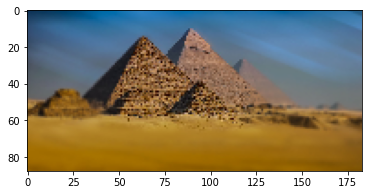

In [ ]:
plt.imshow(img)

In [ ]:
#Define a 3*3 filter to apply (Gradient for x-direction from Sobel filter)
filter = [[1,0,-1],
          [1,0,-1],
          [1,0,-1]]

#Create placeholder for filtered image
filtered_image = np.full((img.shape[0] - 2, img.shape[1] - 2, 3), 0).astype(int)

In [ ]:
#To apply the filter we iterate over the rows and columns

for row in range(img.shape[0]): #stride is 1
  for col in range(img.shape[1]): #stride is 1
    if row > 2 and col > 2:
      #Apply filter on first channel of image and for each section of the image we multiply the section with filter and sum it up using np.sum. This gives us the activation of the filter in the correspoinding area.
      filtered_image[row - 2:row, col -2:col, :] = np.sum(img[row-3:row, col -3:col, 0]*filter).astype(int)
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(86, 181, 3)

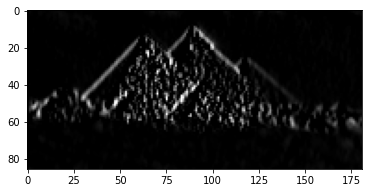

In [ ]:
#Display detected edges
plt.imshow(filtered_image, vmin = filtered_image.min(), vmax = filtered_image.max())
filtered_image.shape

In [ ]:
#The way the filter works is that they show high activation values whenever the specific pattern the filter is looking for in the local region. Filter is designed to detect one specific property e.g. edge detection filter just looks for edges.
# CNNs learn several filters and therefore learn to extract features automatically by looking at the training data that we feed in.

In [ ]:
#Convolutional layer
#It is the core building block of the CNN.
#This layer simply applies the filter on the image and outputs the feature map which is just another image. This is also called discrete convolution.
#The feature map shows the activation. Which means it shows where the visual patter of the filter is present in our image.
#The filter is now a learnable matrix. This means that the values are determined by the CNN in the learning process. 
#They are initialized randomly using a gaussian distribution and then adjusted using backpropagation.

In [ ]:
#Set up GPU
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [ ]:
#Connect google drive with colab
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [ ]:
#Paths and placeholders for files
train_root = "/content/drive/MyDrive/train"
test_root = "/content/drive/MyDrive/test"
train_path_dict = {}
test_path_dict = {}


In [ ]:
#Loop over all files and store their path in dictionary

import os

# Go through all train folders
for subdir, dirs, files in os.walk(train_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "train":
        train_path_dict[wonder] = paths

# Go through all test folders
for subdir, dirs, files in os.walk(test_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "test":
        test_path_dict[wonder] = paths

# Show example
test_path_dict

{'chichen_itza': ['/content/drive/MyDrive/test/chichen_itza/chichen-itza-683193_1280.jpg',
  '/content/drive/MyDrive/test/chichen_itza/pyramid-1093924_1280.jpg'],
 'christ_the_redeemer_rio': ['/content/drive/MyDrive/test/christ_the_redeemer_rio/pexels-photo-2818895.jpeg',
  '/content/drive/MyDrive/test/christ_the_redeemer_rio/pexels-photo-2868248.jpeg'],
 'city_of_petra': ['/content/drive/MyDrive/test/city_of_petra/petra-2067946_1280.jpg',
  '/content/drive/MyDrive/test/city_of_petra/petra-jordan-543450_1280.jpg'],
 'colosseum_rome': ['/content/drive/MyDrive/test/colosseum_rome/colosseum-3676165_1280.jpg',
  '/content/drive/MyDrive/test/colosseum_rome/italy-2478805_1280.jpg'],
 'great_pyramid_of_giza': ['/content/drive/MyDrive/test/great_pyramid_of_giza/giza-1756946_1280.jpg',
  '/content/drive/MyDrive/test/great_pyramid_of_giza/cairo-1051380_1280.jpg'],
 'great_wall_of_china': ['/content/drive/MyDrive/test/great_wall_of_china/great-wall-201465_1280.jpg',
  '/content/drive/MyDrive/test

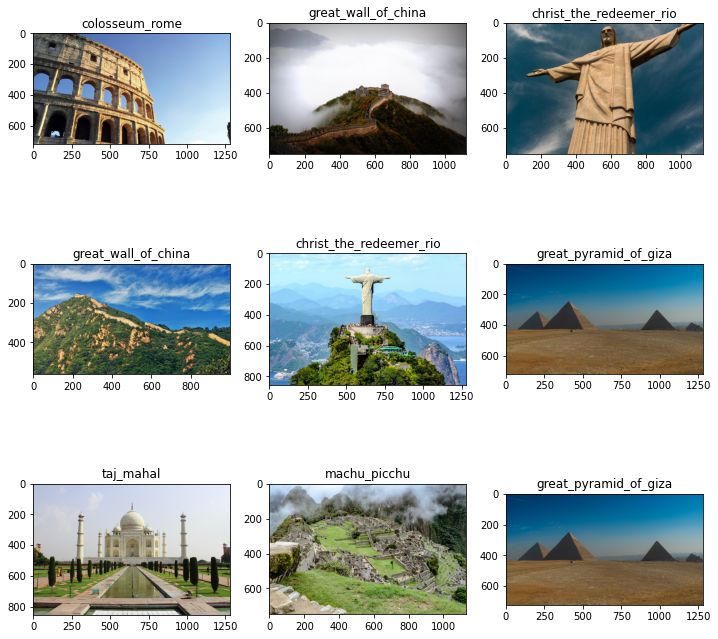

In [ ]:
#Randomly select images from different folders and display them in a grid
import matplotlib.pyplot as plt
import random

num_images_per_axis = 3
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(num_images_per_axis**2):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  # Randomly select wonder
  wonder_type = random.choice(list(train_path_dict.keys()))
  ax.title.set_text(wonder_type)
  # Select random file index
  index = random.choice(range(0,7))
  img = plt.imread(train_path_dict[wonder_type][index])
  ax.imshow(img)

In [ ]:
#Observations on the above images:
# RGB images with 3 color channels --> data shape is width, height, channel = 3
#Different sizes for the images


In [ ]:
# Load train dataset using PyTorch
train_dataset = torchvision.datasets.ImageFolder(
        root=train_root, # This is the folder containing the image-folders
        transform=transforms.Compose([
                      transforms.Resize((512,512)),
                      transforms.ToTensor()
        ])
)

#Load the test data using PyTorch
test_dataset = torchvision.datasets.ImageFolder(
        root=test_root, # This is the folder containing the image-folders
        transform=transforms.Compose([
                      transforms.Resize((512,512)),
                      transforms.ToTensor()
        ])
)

In [ ]:
#having a look at the dataset
print("Dataset >>> ", train_dataset)
print("Sample >>> ", train_dataset[0])
print("Sample shape Channels x Height x Width >>> ", train_dataset[0][0].size())

Dataset >>>  Dataset ImageFolder
    Number of datapoints: 64
    Root location: /content/drive/MyDrive/train
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Sample >>>  (tensor([[[0.6510, 0.6549, 0.6549,  ..., 0.6863, 0.6824, 0.6784],
         [0.6510, 0.6510, 0.6549,  ..., 0.6863, 0.6863, 0.6824],
         [0.6471, 0.6510, 0.6510,  ..., 0.6863, 0.6863, 0.6824],
         ...,
         [0.4000, 0.4157, 0.3961,  ..., 0.3765, 0.3843, 0.4353],
         [0.4039, 0.4235, 0.4039,  ..., 0.3412, 0.3725, 0.4353],
         [0.3882, 0.4196, 0.4039,  ..., 0.3020, 0.3373, 0.3882]],

        [[0.6392, 0.6431, 0.6431,  ..., 0.6980, 0.6941, 0.6902],
         [0.6392, 0.6392, 0.6431,  ..., 0.6980, 0.6980, 0.6941],
         [0.6353, 0.6392, 0.6392,  ..., 0.6980, 0.6980, 0.6941],
         ...,
         [0.4706, 0.4863, 0.4667,  ..., 0.4471, 0.4510, 0.5020],
         [0.4745, 0.49

In [ ]:
#Observations
#ToTensor automatically converts images to [0,1]
#Labels are automatically converted to numbers
#Indexing the dataset will return a tuple

In [ ]:
#Rules of thumb to build a CNN model
#Start with baseline models --> Conv-pool or Conv-Conv-Pool pattern
#Use filters with odd sizes(3*3, 5*5, 7*7) --> Reason for this is that these filters always have a centered pixel that preserves the location of the activation after filtering
#Start with smaller filters to capture local features and increase their size
#Number of channels should be low in the first layers and then increase as the network gets deeper as we want to capture more high level features in the higher layers therefore needing multiple feature maps. The low level features are not so variant and we can start with only a few channels.
#Also, the pooling layers compress our filtered representations and we need more channels to avoid an information bottleneck. 
# Use padding to maintain the shape
#For pooling layers use 2*2 or 3*3 kernels
#keep adding layers until the model overfits
#Tune hyperparameters such as the tuning rate and activation functions

In [ ]:
#Data Loaders
batch_size = 8

#Create the train dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

#Create the test dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = True
)

###Training a CNN

In [ ]:
#We can create a CNN simply by inheriting from the nn module from pytorch. The creation in most cases follows the same pattern.
# In the __init__ function we define the layers
#In the __init__ function we have the pattern --> (conv-conv-pool)*2
#After this, we have the fully connected part which means we have the classifier and there we have three linear layers.
#One of the FC layers takes the input of the last pooling layer and converts it into 120 neurons
#Then we transform it into a smaller size and finally we have 8 output units which stand for the 8 classes we have in our chosen dataset

#The forward function will be called when we feed the data into the network
#In forward function we simply stack the layers
#Linear = Fully connected/dense
#x is our input image which will be fed into the first convolution then an activation function (relu) then the second convolution and then the pooling 
#The same happens with the second stack of these filters

#After this we apply the flatten
#Then we pass the data further through our fully connected layers until we end up with output of 8 classes


#Arcitecture:
#We start with 3 in_channels equating to RGB and we apply 5 filters (out_channels) which means we get 5 feature maps
#The 5 feature maps will then be filtered with 10 filters, so we get 10 feature maps and so on until we have 30 feature maps in the final layer
#First we use kernel size of 3*3 which means we use 3*3 filters and then we use kernel size 5*5 which means we use 5*5 filters

#Flattening operations
#On going through the feature extraction, our conv pool pattern, we observe several 2D feature maps
#We then flatten the feature map. This means that we convert the feature matrix to an array by taking each row or column and appending it.
#The length of the array is equal to the number of neurons in the input layer of the dense network

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
  def __init__(self):

    #Initialize super class
    super(CNN, self).__init__()
    
    #Define the architecture of CNN
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = 3, padding = 1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv3 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5, padding = 2)
    self.conv4 = nn.Conv2d(in_channels = 20, out_channels = 30, kernel_size = 5, padding = 2)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    #Classifier, input is 30 feature maps with 128 X 128 values
    self.fc1 = nn.Linear(30*128*128, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,8)
  
  def forward(self, x):
    #Feature extraction
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

    #Flatten and feed to classifier
    x =x.flatten(start_dim = 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=491520, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)

In [ ]:
#The second way of building a CNN is using the torch.nn.Sequential module

class CNN_sequential(nn.Module):
  def __init__(self):
    super(CNN_sequential, self).__init__()

    self.cnn_sequential = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 20, out_channels = 30, kernel_size = 2),
        nn.ReLU(inplace = True)
    )

    self.classifier = nn.Sequential(
        nn.Linear(30*126*126, 120),
        nn.Linear(120,84),
        nn.Linear(84,8)
    )

  def forward_sequential(self,x):
    x = self.cnn_sequential(x)
    x = self.classifier(x)
    return x

###Optmizer and Loss

Most commonly used optimizer is <b>Adam</b>. This stands for Adaptive Moment Estimaton which is an advanced optmization algorithm. 
For loss function we use <b>cross entropy loss.</b>

In [ ]:
import torch.optim as optim

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [ ]:
#Cross entropy loss applies softmax implicitly
#Adam is generall a good choice as optimizer

In [ ]:
def train_model(early_stopping=True, epochs=50):
  """ Training the model in a loop of epochs """
  epoch_train_losses = []
  epoch_test_losses = []
  current_best_loss = np.inf
  early_stopping_counter = 0
  early_stopping_patience = 2

  # loop over the dataset multiple times
  for epoch in range(epochs):  
    for i, batch in enumerate(train_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # Implicitly uses softmax
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
    # Print loss stats every x epochs
    if epoch % 1 == 0: 
      # Convert outputs
      outputs = output_to_label(outputs)
      # Calculate train accuracy
      train_acc = calculate_accuracy(labels.detach().cpu().numpy(), outputs)
      test_acc, test_loss = test()
      print(f"Epoch: {epoch} | train_loss: {loss} | train_acc: {train_acc} \
      | test_loss: {test_loss} | test_acc: {test_acc}")
      epoch_train_losses.append(loss.item())
      epoch_test_losses.append(test_loss)

      # Early stopping
      if test_loss < current_best_loss:
        current_best_loss = test_loss
        early_stopping_counter = 0
      else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience and early_stopping:
          break

  print('Finished Training')
  return epoch_train_losses, epoch_test_losses

def calculate_accuracy(labels, predictions):
  """ Calculates the % of correct predictions """
  labels = np.asarray(labels)
  predictions = np.asarray(predictions)
  correct = (labels == predictions)
  return correct.sum() / correct.size

def test():
  """ Evaluating the model on the test data """

  all_labels = []
  all_predictions = []
  all_losses = []

  # Iterate over batches of test loader
  for i, batch in enumerate(test_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Get the output
        outputs = net(inputs)
        # Calculate loss
        loss = cross_entropy_loss(outputs, labels)
        all_losses.append(loss.item())
        # Convert outputs 
        outputs = output_to_label(outputs)
        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(outputs)
  # Calculate accuracy with all test data
  test_acc = calculate_accuracy(all_labels, all_predictions)
  return test_acc, sum(all_losses)/len(test_loader)

def output_to_label(output):
  # Apply softmax
  outputs_prob = F.softmax(output)
  return np.argmax(outputs_prob.detach().cpu().numpy(), axis=1)

In [ ]:
epoch_train_losses, epoch_test_losses = train_model()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | train_loss: 2.2638142108917236 | train_acc: 0.0       | test_loss: 2.083687901496887 | test_acc: 0.125
Epoch: 1 | train_loss: 2.1619150638580322 | train_acc: 0.0       | test_loss: 2.0692050457000732 | test_acc: 0.125
Epoch: 2 | train_loss: 2.050443649291992 | train_acc: 0.25       | test_loss: 2.046370506286621 | test_acc: 0.25
Epoch: 3 | train_loss: 2.0126609802246094 | train_acc: 0.125       | test_loss: 2.011054277420044 | test_acc: 0.1875
Epoch: 4 | train_loss: 1.9666763544082642 | train_acc: 0.125       | test_loss: 1.9665696620941162 | test_acc: 0.25
Epoch: 5 | train_loss: 1.944472074508667 | train_acc: 0.25       | test_loss: 1.8875900506973267 | test_acc: 0.25
Epoch: 6 | train_loss: 1.5791270732879639 | train_acc: 0.25       | test_loss: 1.782871127128601 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.4480829238891602 | train_acc: 0.375       | test_loss: 1.6699243783950806 | test_acc: 0.375
Epoch: 8 | train_loss: 1.1460860967636108 | train_acc: 0.625       | test_loss

###Investigating the predictions

In [ ]:
import numpy as np

# Get next batch 
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

# Get outputs of model
outputs = net(images)
labels = np.array(labels)

# Cross Entropy loss already applied Softmax, now we need to do it manually
outputs_prob = F.softmax(outputs).detach().cpu().numpy()
# Get most likely class
outputs = np.argmax(outputs_prob, axis=1)
probabilities = np.max(outputs_prob, axis=1)

# Print class probabilities, predictions and ground truths
print(outputs_prob)
print(outputs)
print(labels)

# Map the numeric values back to classes
txt_labels = list(train_dataset.class_to_idx.keys())
outputs = [txt_labels[i] for i in outputs]
labels = [txt_labels[i] for i in labels]

[[1.6143456e-05 1.3332751e-04 3.9386774e-05 3.7585830e-06 4.9693057e-07
  2.3744093e-01 7.6234812e-01 1.7919623e-05]
 [5.3438000e-02 1.8107995e-03 1.5249978e-01 1.6190715e-03 5.4767527e-02
  9.0682041e-03 1.7553132e-02 7.0924342e-01]
 [2.4124476e-01 1.2114480e-02 2.5757950e-02 2.6144948e-02 1.0208167e-01
  7.9892939e-03 1.6265970e-03 5.8304030e-01]
 [3.0978853e-01 4.4631753e-02 2.2634419e-03 1.0267921e-01 6.1735492e-02
  6.3098319e-02 1.5914319e-02 3.9988893e-01]
 [1.4570590e-02 1.0199935e-04 1.4152615e-02 1.2048546e-02 9.5478016e-01
  2.7713741e-04 2.1454666e-04 3.8542643e-03]
 [3.3169862e-02 7.0790928e-03 4.0851027e-01 2.1946618e-02 2.7549112e-01
  3.7949026e-02 6.8895072e-02 1.4695896e-01]
 [7.2621569e-02 2.0494072e-02 2.4488856e-01 2.3720773e-02 2.6426357e-01
  3.1831190e-02 1.1531452e-01 2.2686569e-01]
 [5.8342610e-02 1.3993411e-04 1.6475701e-03 6.6904113e-02 8.6744422e-01
  1.0615424e-04 5.4114244e-05 5.3613079e-03]]
[6 7 7 7 4 2 4 4]
[6 7 5 7 4 2 3 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


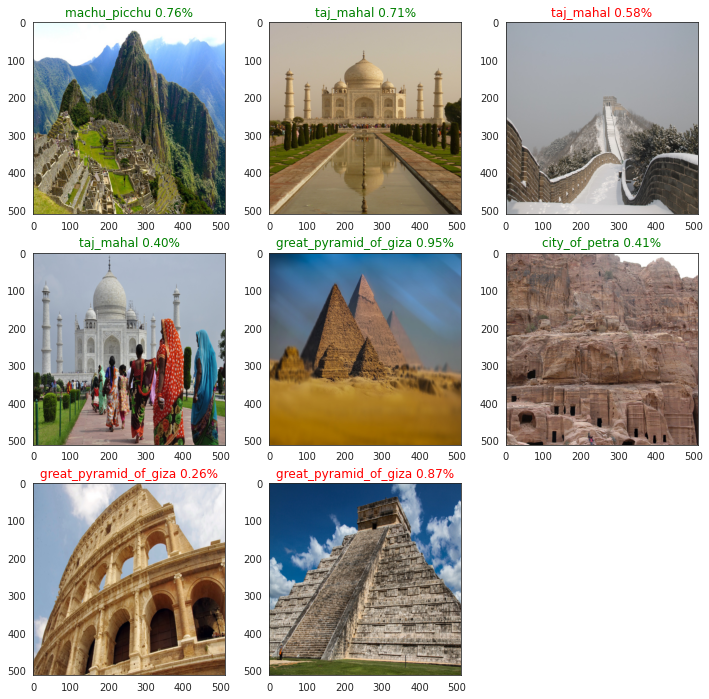

In [ ]:
import seaborn as sns


sns.set_style("white")
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(batch_size):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  wonder_type = outputs[i]
  groundtruth = labels[i]
  if groundtruth == wonder_type:
    color = "green"
  else:
    color = "red"
  img = images[i]
  img = img.permute(1,2,0).detach().cpu().numpy()
  ax.set_title(wonder_type + f" {probabilities[i]:.2f}%", color=color)
  ax.imshow(img)